# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Add any additional libraries or submodules below
#import missingno as msno
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from imblearn.over_sampling import SMOTE
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
#import shap

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay

In [35]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

C:\Users\京柒柒\AppData\Local\Temp\ipykernel_21744\2212289888.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

**3.1 Data Preparation**

In [3]:
# Proportion view of loan_status
d["loan_status"].value_counts(normalize=True) * 100

prepaid    62.9795
active     36.6475
default     0.3730
Name: loan_status, dtype: float64

统计结果显示绝大部分贷款已提前还清或仍在正常偿还，违约样本极少。数据显示，在20万笔贷款中，违约约仅占0.37%，呈现出高度不平衡的类别分布。由于“active”贷款尚未有最终结果，根据业务指示，我们只关注区分提前还清和违约两类。因此，在后续建模中，我们将过滤掉loan_status为“active”的贷款，仅使用“prepaid”和“default”两类来训练模型，并将“default”视作正类。
Statistical results show that the vast majority of loans have either been prepaid or are still in normal repayment, with default cases being relatively rare. The data indicates that among 200000 loans, defaults account for only about 0.37%, reflecting a highly imbalanced class distribution. Since “active” loans do not yet have a final outcome, and based on business guidance, we focus only on distinguishing between prepaid and defaulted loans. Therefore, in the subsequent modeling process, we will filter out loans with a `loan_status` of “active” and use only “prepaid” and “default” loans for training, treating “default” as the positive class. This approach avoids labeling unresolved loans as negative samples, thereby enhancing the model's accuracy in predicting future defaults.

**Add new feature**

In [36]:
# Add a new feature 'is_harp_loan' to indicate if a loan is a HARP l
d['is_harp_loan'] = ((d['rr_ind'] == 'Y') & (d['ltv'] > 80)).astype('object')

# Add a new feature 'msa' to indicate if loan is in MSA or MD
d['msa'] = d['cd_msa'].notnull().astype('object')

# Add a new feature 'Nat_A' to indicate where the loan belong
d['zipcode'] = d['zipcode'].astype(str)

# Add a new feature for the national area code
d['Nat_A'] = d['zipcode'].apply(lambda x: '0' if len(x) < 5 else x[0]).astype('object')

d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status,is_harp_loan,msa,Nat_A
0,809,201705,N,204704,NaN,0,1,P,75,38,...,NaN,9,NaN,2,N,7,prepaid,False,False,1
1,702,201703,N,203202,NaN,0,1,P,80,36,...,NaN,9,NaN,2,N,7,active,False,False,4
2,792,201703,N,204702,NaN,0,1,S,60,36,...,NaN,9,NaN,2,N,7,prepaid,False,False,4
3,776,201703,N,204702,NaN,0,1,S,80,18,...,NaN,9,NaN,2,N,7,prepaid,False,False,1
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,NaN,9,NaN,2,N,7,active,False,True,8


**Remove irrelevant features**:

`id_loan`: change to index

`prod_type`: constantly "FRM" throughout the dataset and shows no variation, drop

`ppmt_pnlty`: consistently "N", no information gain, drop

`io_ind`: consistently "N", no information gain, drop

`dt_matr`: can be derived from the `dt_first_pi` and `orig_loan_term` and are of limited predictive value, drop (explain why keep `dt_first_pi`)

`id_loan_rr`and `rr_ind`: relate to loan refinancing/ have multicollinearity, drop

`servicer_name` and `seller_name`: drop, (by references)

`cd_msa` and `zipcode`: creat the new features which summary these features (by references)

In [37]:
# Replace Index with id_loan
d = d.set_index('id_loan')

# Remove irrelevant features
drop_cols = ['prod_type', 'ppmt_pnlty', 'io_ind', 'id_loan_rr','rr_ind','dt_matr','cd_msa','zipcode', 'seller_name','servicer_name']
d.drop(columns=[c for c in drop_cols if c in d.columns], inplace=True)

d.head()

,fico,dt_first_pi,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,flag_sc,program_ind,property_val,mi_cancel_ind,loan_status,is_harp_loan,msa,Nat_A
id_loan,,,,,,,,,,,,,,,,,,,,,
F17Q10000002,809,201705,N,0,1,P,75,38,195000,75,...,360,1,NaN,9,2,7,prepaid,False,False,1
F17Q10000017,702,201703,N,0,1,P,80,36,187000,76,...,180,2,NaN,9,2,7,active,False,False,4
F17Q10000064,792,201703,N,0,1,S,60,36,87000,60,...,360,2,NaN,9,2,7,prepaid,False,False,4
F17Q10000065,776,201703,N,0,1,S,80,18,106000,80,...,360,2,NaN,9,2,7,prepaid,False,False,1
F17Q10000073,790,201703,N,0,1,I,75,42,75000,75,...,360,1,NaN,9,2,7,active,False,True,8


**Handling NaN Values and Pseudo-NaN Values**:

numerical:

`fico`: typically ranges from 300 to 850, but a value of 9999 indicates not available

`mi_pct`, `cltv`, `dti` and `ltv`: a value of 999 indicates not available

`property_val`: a value of 9 indicates not available

categorical:

`flag_sc`: 'NaN' indicates NaN

`program_ind`: '9' indicates NaN

`mi_cancel_ind`:  '7' and '9' indicate NaN

In [38]:
# Replace pseudo-missing numeric codes with NaN
d.replace({'fico': {9999: np.nan}, 'mi_pct': {999: np.nan}, 'cltv': {999: np.nan}, 'dti': {999: np.nan},
           'ltv': {999: np.nan}, 'cnt_units': {99: np.nan}, 'property_val': {9: 'N'}}, inplace=True)

# Replace categorical pseudo-missing codes with consistent label
d['flag_sc'] = d['flag_sc'].fillna('N')
d['program_ind'] = d['program_ind'].replace('9', np.nan)
d['program_ind'] = d['program_ind'].fillna('N')
d['mi_cancel_ind'] = d['mi_cancel_ind'].replace('7', np.nan)
d['mi_cancel_ind'] = d['mi_cancel_ind'].fillna('N')

d.head()

,fico,dt_first_pi,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,flag_sc,program_ind,property_val,mi_cancel_ind,loan_status,is_harp_loan,msa,Nat_A
id_loan,,,,,,,,,,,,,,,,,,,,,
F17Q10000002,809.0,201705,N,0.0,1,P,75.0,38.0,195000,75.0,...,360,1,N,N,2,N,prepaid,False,False,1
F17Q10000017,702.0,201703,N,0.0,1,P,80.0,36.0,187000,76.0,...,180,2,N,N,2,N,active,False,False,4
F17Q10000064,792.0,201703,N,0.0,1,S,60.0,36.0,87000,60.0,...,360,2,N,N,2,N,prepaid,False,False,4
F17Q10000065,776.0,201703,N,0.0,1,S,80.0,18.0,106000,80.0,...,360,2,N,N,2,N,prepaid,False,False,1
F17Q10000073,790.0,201703,N,0.0,1,I,75.0,42.0,75000,75.0,...,360,1,N,N,2,N,active,False,True,8


To handle pseudo-NaN values, we apply different strategies based on variable type. For numerical features, special codes such as 999 or 9999 are replaced with NaN, since these values do not carry valid quantitative meaning and should be treated as true missing data. This allows for appropriate downstream handling, such as imputation or row exclusion, and prevents misleading the model with extreme or invalid values.

In contrast, for categorical features, pseudo-NaN codes like '9' or '7' are replaced with a consistent label 'N', representing “Not Available.” This preserves the categorical structure of the data while allowing the model to treat missingness as a distinct, learnable category.

In [40]:
# Convert dt_first_pi, cnt_units, cnt_borr, property_val column to object class since it is categorical
d['dt_first_pi'] = d['dt_first_pi'].rank(method='dense').astype('object')
d['property_val'] = d['property_val'].astype('object')
d['cnt_borr'] = d['cnt_borr'].apply(lambda x: 'single' if x == 1 else 'multiple')

d.head()

,fico,dt_first_pi,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,flag_sc,program_ind,property_val,mi_cancel_ind,loan_status,is_harp_loan,msa,Nat_A
id_loan,,,,,,,,,,,,,,,,,,,,,
F17Q10000002,809.0,4.0,N,0.0,1,P,75.0,38.0,195000,75.0,...,360,single,N,N,2,N,prepaid,False,False,1
F17Q10000017,702.0,2.0,N,0.0,1,P,80.0,36.0,187000,76.0,...,180,multiple,N,N,2,N,active,False,False,4
F17Q10000064,792.0,2.0,N,0.0,1,S,60.0,36.0,87000,60.0,...,360,multiple,N,N,2,N,prepaid,False,False,4
F17Q10000065,776.0,2.0,N,0.0,1,S,80.0,18.0,106000,80.0,...,360,multiple,N,N,2,N,prepaid,False,False,1
F17Q10000073,790.0,2.0,N,0.0,1,I,75.0,42.0,75000,75.0,...,360,single,N,N,2,N,active,False,True,8


In [41]:
# 保留未偿还的贷款记录（loan_status == 'active'）
active_loans = d[d['loan_status'] == 'active'].copy()

# Filter out loans that are still being repaid, keeping only prepaid and defaulted samples
d = d[d['loan_status'] != 'active'].copy()

# Add a new label column: default = 1, prepaid = 0
d['default_flag'] = (d['loan_status'] == 'default').astype(int)

# Drop the 'loan_status'
d.drop(columns=['loan_status'], inplace=True)

d.head()

,fico,dt_first_pi,flag_fthb,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,flag_sc,program_ind,property_val,mi_cancel_ind,is_harp_loan,msa,Nat_A,default_flag
id_loan,,,,,,,,,,,,,,,,,,,,,
F17Q10000002,809.0,4.0,N,0.0,1,P,75.0,38.0,195000,75.0,...,360,single,N,N,2,N,False,False,1,0
F17Q10000064,792.0,2.0,N,0.0,1,S,60.0,36.0,87000,60.0,...,360,multiple,N,N,2,N,False,False,4,0
F17Q10000065,776.0,2.0,N,0.0,1,S,80.0,18.0,106000,80.0,...,360,multiple,N,N,2,N,False,False,1,0
F17Q10000176,687.0,2.0,N,0.0,1,P,80.0,45.0,619000,75.0,...,360,multiple,N,N,2,N,False,True,9,0
F17Q10000301,758.0,2.0,N,0.0,1,P,53.0,NaN,64000,53.0,...,180,single,N,N,3,N,False,False,9,0


In [9]:
d["default_flag"].value_counts()

0    125959
1       746
Name: default_flag, dtype: int64

In [42]:
# Create a list of categorical columns
categorical_features = d.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

# Create a list of numerical columns
numerical_features = d.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['dt_first_pi', 'flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'loan_purpose', 'cnt_borr', 'flag_sc', 'program_ind', 'property_val', 'mi_cancel_ind', 'is_harp_loan', 'msa', 'Nat_A']
['fico', 'mi_pct', 'cnt_units', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']


**3.2 Test-Training Split**

In [43]:
# Split the data into training and testing sets (stratified by default label)
X = d.drop(columns=['default_flag'])
y = d['default_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print("Training set size:", X_train.shape, "Default rate:", y_train.mean())
print("Test set size:", X_test.shape, "Default rate:", y_test.mean())

Training set size: (101364, 24) Default rate: 0.0058896649698117675
Test set size: (25341, 24) Default rate: 0.0058797995343514466


**3.3 Missing data check**

In [44]:
missing_counts = X_train[numerical_features].isnull().sum()
missing_percent = (missing_counts / len(X_train)) * 100
# Get the maximum missing percentage
# max_missing = missing_percent.max()
# Visualize missingness
# msno.matrix(X_train, figsize=(9, 2), fontsize=10, sparkline=False)
# plt.title("Missing Values Matrix")
# plt.show()
# print(f"Maximum missing percentage for a variable: {max_missing:.2f}%")
print(missing_percent[missing_percent > 0])

fico    0.019731
cltv    0.000987
dti     1.019099
ltv     0.000987
dtype: float64


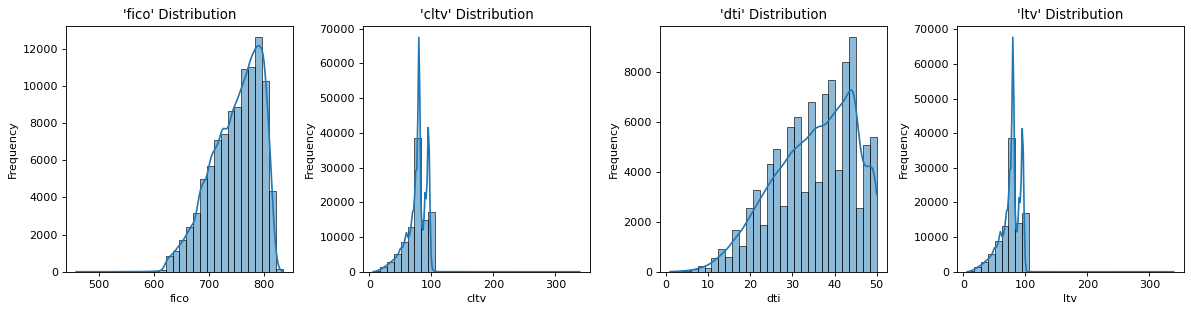

In [13]:
# Select numeric columns
numeric_missing = ['fico', 'cltv', 'dti', 'ltv']
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) 
for i, col in enumerate(numeric_missing):
    sns.histplot(X_train[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"'{col}' Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Given all four of the numerical features with missing values are skewed, we will implement median imputation in our preprocessing pipeline to best replace these missing values. 

**3.4 Investigating Relationships**

<Axes: >

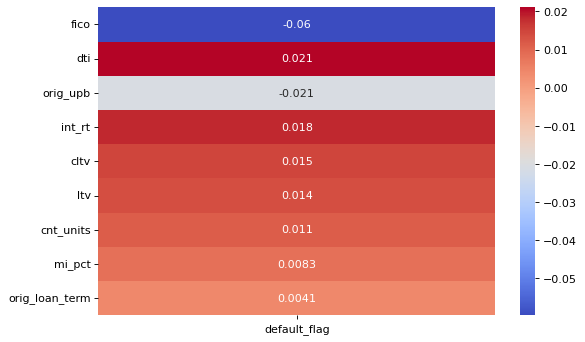

In [14]:
corr_matrix = pd.concat([X_train, y_train], axis=1).corr(numeric_only=True)
target_corr = corr_matrix[['default_flag']].drop('default_flag').sort_values(by='default_flag', key=abs, ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm')

从相关性热力图可以看出，所有数值变量与违约标签 default_flag 之间的线性相关性都非常弱。这可能是由于数据集中违约样本极少，类别严重不平衡，导致皮尔森相关系数无法准确衡量变量的重要性。为了缓解这种问题，我们将在后续采用 SMOTE 技术对违约样本进行过采样，以提高模型对少数类的识别能力。

The correlation heatmap shows that all numerical features have very weak linear relationships with the target variable default_flag. This is likely due to the highly imbalanced nature of the dataset, where the proportion of default cases is extremely low. In such settings, traditional correlation metrics tend to understate the predictive value of features, as the minority class is underrepresented in the statistical estimation. To address this, we apply SMOTE (Synthetic Minority Over-sampling Technique) to rebalance the dataset by generating synthetic default samples. This improves the model’s ability to learn patterns associated with the rare class and enhances performance on imbalanced classification tasks.

**3.5 Data Transformations**

Since the variables are not on the same scale, we apply standardisation. Explain.

由于各变量的量纲不同，我们对数据进行了标准化处理。运用在pipeline中

**3.6 Feature Engineering**

To transform the categorical variables, we employ One-Hot Encoding. Explain

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

**4.1 Pipeline and Oversampling(SMOTE)**

In [15]:
# Using Pipeline for numerical and categorical
# Create lists for impution type
median_impute = ['fico', 'cltv', 'dti', 'ltv', 'mi_pct']
# Numerical imputer pipeline
numerical_transformer = Pipeline([
    ('impute', ColumnTransformer([
    ("median_impute", SimpleImputer(strategy='median'), median_impute)
], remainder='passthrough')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('to_str', FunctionTransformer(lambda x: x.astype(str))),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Refit and transform the training set; transform the test set
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

print("Encoded feature matrix shape (training set):", X_train_enc.shape)

Encoded feature matrix shape (training set): (101364, 161)


After encoding, the dimensionality of the training feature matrix increases significantly from 24 to 165 due to the one-hot encoding of categorical variables. The pipeline ensures that the same transformations are consistently applied to both the training and testing data.

编码后，训练集特征矩阵的维度增加明显从24到165，这是由于对类别变量进行了独热编码。Pipeline确保相同变换应用于训练和测试数据。

类别不平衡处理： 在训练模型前，需要应对违约样本过少的问题。我们采用SMOTE算法对训练集过采样正类，使违约样本数量增加至与非违约相当，从而平衡训练数据。SMOTE通过插值合成新的少数类样本，较随机过采样能增加多样性。这里使用imblearn.over_sampling.SMOTE进行处理。为防止数据泄漏，我们仅对训练集做过采样，测试集保持真实分布。

In [16]:
# Apply SMOTE to oversample the training set
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

print("Resampled training set shape:", X_train_res.shape, 
      "Positive class ratio:", y_train_res.mean())

Resampled training set shape: (201534, 161) Positive class ratio: 0.5


After oversampling, the number of training samples increases significantly, with default and non-default cases each accounting for 50%. For example, the original training set contained only a few hundred default cases. With SMOTE, a large number of synthetic default samples were generated, resulting in approximately 100,000 samples for each class. This balanced distribution provides the model with sufficient default cases to learn from, helping to alleviate the issue of the model being biased toward predicting the majority class. In the subsequent model training, we will use `X_train_res` and `y_train_res` as the training data.

过采样后训练集样本数成倍增加，违约与非违约样本数各占50%。例如，原训练集中违约样本仅几百条，经过SMOTE生成了大量合成违约样本，正负样本均约10万余条，各占一半，为模型提供了足够的违约案例学习。这样处理能缓解模型偏向预测多数类的问题。在后续模型训练中，我们将使用X_train_res, y_train_res作为训练数据。

**Using Filter and Random Forest to remove features again**

In [29]:
# Step1: Filter-based feature selection
filter_selector = SelectKBest(score_func=f_classif, k=50)
filter_selector.fit(X_train_res, y_train_res)
X_train_res_filter = filter_selector.transform(X_train_res)
# Step2: Random Forest feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_res_filter, y_train_res)
model_selector = SelectFromModel(rf, prefit=True, threshold="median")
X_train_final = model_selector.transform(X_train_res_filter)
print("X_train_final shape:", X_train_final.shape)

X_train_final shape: (201534, 25)


In [30]:
numeric_features = numerical_features
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = onehot.get_feature_names_out(categorical_features)
feature_names_encoded = np.concatenate([numeric_features, categorical_feature_names])
# Step1 selection
filter_support = filter_selector.get_support(indices=True)
# Step2 selection based on Step1
rf_support = model_selector.get_support(indices=True)
final_feature_indices = filter_support[rf_support]
# Final feature selection
final_feature_names = feature_names_encoded[final_feature_indices]
print(final_feature_names)

['fico' 'mi_pct' 'cnt_units' 'cltv' 'dti' 'ltv' 'int_rt'
 'dt_first_pi_11.0' 'dt_first_pi_13.0' 'flag_fthb_N' 'flag_fthb_Y'
 'channel_R' 'st_FL' 'prop_type_PU' 'prop_type_SF' 'loan_purpose_C'
 'cnt_borr_1' 'cnt_borr_2' 'property_val_1' 'property_val_3' 'msa_True'
 'Nat_A_0' 'Nat_A_2' 'Nat_A_3' 'Nat_A_8']


In [31]:
X_test_final = X_test_enc[:, final_feature_indices]

**4.2 Initial Model Training and Comparison**

In [34]:
# 使用 StratifiedKFold 进行交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义 Logistic Regression 模型（保持你的 pipeline 不变）
logistic = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# 交叉验证预测（通过cross_val_predict返回每一折的预测结果）
y_pred_cv = cross_val_predict(logistic, X_train_final, y_train_res, cv=cv)
y_prob_cv = cross_val_predict(logistic, X_train_final, y_train_res, cv=cv, method='predict_proba')[:, 1]

# 计算交叉验证的指标
metrics = {
    'Accuracy': accuracy_score(y_train_res, y_pred_cv),
    'Precision': precision_score(y_train_res, y_pred_cv),
    'Recall': recall_score(y_train_res, y_pred_cv),
    'F1-score': f1_score(y_train_res, y_pred_cv),
    'AUC': roc_auc_score(y_train_res, y_prob_cv)
}

print("=== Logistic Regression with Cross-Validation ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# 输出 classification_report 评估更多细节
print(classification_report(y_train_res, y_pred_cv))

# 混淆矩阵
confusion_matrix(y_train_res, y_pred_cv)

=== Logistic Regression with Cross-Validation ===
Accuracy: 0.716
Precision: 0.710
Recall: 0.731
F1-score: 0.720
AUC: 0.783
              precision    recall  f1-score   support

           0       0.72      0.70      0.71    100767
           1       0.71      0.73      0.72    100767

    accuracy                           0.72    201534
   macro avg       0.72      0.72      0.72    201534
weighted avg       0.72      0.72      0.72    201534



array([[70643, 30124],
       [27121, 73646]], dtype=int64)

In [20]:
# 将数据集分割为较小的训练集（例如，10%）
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_final, y_train_res, train_size=0.1, stratify=y_train_res, random_state=0)

# 使用 StratifiedKFold 进行交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义 SVM 模型（保持你的 pipeline 不变）
svm = Pipeline([
    ('clf', SVC(kernel='rbf', probability=True, random_state=42))
])

# 交叉验证预测（通过 cross_val_predict 返回每一折的预测结果）
y_pred_cv = cross_val_predict(svm, X_train_sub, y_train_sub, cv=cv)
y_prob_cv = cross_val_predict(svm, X_train_sub, y_train_sub, cv=cv, method='predict_proba')[:, 1]

# 计算交叉验证的指标
metrics = {
    'Accuracy': accuracy_score(y_train_sub, y_pred_cv),
    'Precision': precision_score(y_train_sub, y_pred_cv),
    'Recall': recall_score(y_train_sub, y_pred_cv),
    'F1-score': f1_score(y_train_sub, y_pred_cv),
    'AUC': roc_auc_score(y_train_sub, y_prob_cv)
}

print("=== SVM with Cross-Validation on 10% Subset ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# 输出 classification_report 评估更多细节
print(classification_report(y_train_sub, y_pred_cv))

# 混淆矩阵
confusion_matrix(y_train_sub, y_pred_cv)

=== SVM with Cross-Validation on 10% Subset ===
Accuracy: 0.858
Precision: 0.832
Recall: 0.898
F1-score: 0.864
AUC: 0.936
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     10076
           1       0.83      0.90      0.86     10077

    accuracy                           0.86     20153
   macro avg       0.86      0.86      0.86     20153
weighted avg       0.86      0.86      0.86     20153



array([[8246, 1830],
       [1024, 9053]], dtype=int64)

In [21]:
# 使用 StratifiedKFold 进行交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义 Decision Tree 模型（保持你的 pipeline 不变）
dt = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])

# 交叉验证预测（通过 cross_val_predict 返回每一折的预测结果）
y_pred_cv = cross_val_predict(dt, X_train_final, y_train_res, cv=cv)
y_prob_cv = cross_val_predict(dt, X_train_final, y_train_res, cv=cv, method='predict_proba')[:, 1]

# 计算交叉验证的指标
metrics = {
    'Accuracy': accuracy_score(y_train_res, y_pred_cv),
    'Precision': precision_score(y_train_res, y_pred_cv),
    'Recall': recall_score(y_train_res, y_pred_cv),
    'F1-score': f1_score(y_train_res, y_pred_cv),
    'AUC': roc_auc_score(y_train_res, y_prob_cv)
}

print("=== Decision Tree with Cross-Validation ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# 输出 classification_report 评估更多细节
print(classification_report(y_train_res, y_pred_cv))

# 混淆矩阵
confusion_matrix(y_train_res, y_pred_cv)

=== Decision Tree with Cross-Validation ===
Accuracy: 0.989
Precision: 0.986
Recall: 0.992
F1-score: 0.989
AUC: 0.989
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    100767
           1       0.99      0.99      0.99    100767

    accuracy                           0.99    201534
   macro avg       0.99      0.99      0.99    201534
weighted avg       0.99      0.99      0.99    201534



array([[99334,  1433],
       [  834, 99933]], dtype=int64)

In [22]:
# 使用 StratifiedKFold 进行交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义 Random Forest 模型（保持你的 pipeline 不变）
rf = Pipeline([
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# 交叉验证预测（通过 cross_val_predict 返回每一折的预测结果）
y_pred_cv = cross_val_predict(rf, X_train_final, y_train_res, cv=cv)
y_prob_cv = cross_val_predict(rf, X_train_final, y_train_res, cv=cv, method='predict_proba')[:, 1]

# 计算交叉验证的指标
metrics = {
    'Accuracy': accuracy_score(y_train_res, y_pred_cv),
    'Precision': precision_score(y_train_res, y_pred_cv),
    'Recall': recall_score(y_train_res, y_pred_cv),
    'F1-score': f1_score(y_train_res, y_pred_cv),
    'AUC': roc_auc_score(y_train_res, y_prob_cv)
}

print("=== Random Forest with Cross-Validation ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# 输出 classification_report 评估更多细节
print(classification_report(y_train_res, y_pred_cv))

# 混淆矩阵
confusion_matrix(y_train_res, y_pred_cv)

=== Random Forest with Cross-Validation ===
Accuracy: 0.997
Precision: 0.999
Recall: 0.995
F1-score: 0.997
AUC: 1.000
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    100767
           1       1.00      0.99      1.00    100767

    accuracy                           1.00    201534
   macro avg       1.00      1.00      1.00    201534
weighted avg       1.00      1.00      1.00    201534



array([[100699,     68],
       [   515, 100252]], dtype=int64)

In [23]:
# 使用 StratifiedKFold 进行交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义 KNN 模型（保持你的 pipeline 不变）
knn = Pipeline([
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

# 交叉验证预测（通过 cross_val_predict 返回每一折的预测结果）S
y_pred_cv = cross_val_predict(knn, X_train_final, y_train_res, cv=cv)
y_prob_cv = cross_val_predict(knn, X_train_final, y_train_res, cv=cv, method='predict_proba')[:, 1]

# 计算交叉验证的指标
metrics = {
    'Accuracy': accuracy_score(y_train_res, y_pred_cv),
    'Precision': precision_score(y_train_res, y_pred_cv),
    'Recall': recall_score(y_train_res, y_pred_cv),
    'F1-score': f1_score(y_train_res, y_pred_cv),
    'AUC': roc_auc_score(y_train_res, y_prob_cv)
}

print("=== KNN with Cross-Validation ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# 输出 classification_report 评估更多细节
print(classification_report(y_train_res, y_pred_cv))

# 混淆矩阵
confusion_matrix(y_train_res, y_pred_cv)

=== KNN with Cross-Validation ===
Accuracy: 0.973
Precision: 0.949
Recall: 1.000
F1-score: 0.974
AUC: 0.991
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    100767
           1       0.95      1.00      0.97    100767

    accuracy                           0.97    201534
   macro avg       0.97      0.97      0.97    201534
weighted avg       0.97      0.97      0.97    201534



array([[ 95324,   5443],
       [     2, 100765]], dtype=int64)

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. 先用全量的训练数据来拟合模型（非常重要，否则会报 NotFittedError）
logistic.fit(X_train_final, y_train_res)

# 2. 对测试集做预测：分两步
#    - 二分类结果
y_pred_test = logistic.predict(X_test_final)
#    - 正类(1)的预测概率（用于 AUC、绘制 ROC 等）
y_prob_test = logistic.predict_proba(X_test_final)[:, 1]

# 3. 计算在测试集上的各项指标
accuracy_test  = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test    = recall_score(y_test, y_pred_test)
f1_test        = f1_score(y_test, y_pred_test)
auc_test       = roc_auc_score(y_test, y_prob_test)

print("\n=== Logistic Regression on Test Set ===")
print(f"Accuracy:  {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall:    {recall_test:.3f}")
print(f"F1-score:  {f1_test:.3f}")
print(f"AUC:       {auc_test:.3f}")

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(cm_test)


=== Logistic Regression on Test Set ===
Accuracy:  0.703
Precision: 0.014
Recall:    0.698
F1-score:  0.027
AUC:       0.737

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     25192
           1       0.01      0.70      0.03       149

    accuracy                           0.70     25341
   macro avg       0.51      0.70      0.43     25341
weighted avg       0.99      0.70      0.82     25341

Confusion Matrix on Test Set:
[[17713  7479]
 [   45   104]]


In [25]:
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# 1. 从训练集中抽取一个子集，进行调参
X_sample, y_sample = resample(X_train_final, y_train_res, n_samples=20000, random_state=42, stratify=y_train_res)
param_dist = {
    'clf__n_estimators': randint(80, 151),
    'clf__max_depth': [None, 5, 10, 15, 20],
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 6)
}

# 4. 使用 RandomizedSearchCV 进行随机搜索，5折交叉验证，进行30次随机采样
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=30, cv=cv,
    scoring='f1', random_state=42, n_jobs=-1, verbose=1
)

# 5. 训练模型
random_search.fit(X_sample, y_sample)
print("Best Params:", random_search.best_params_)
print("Best f1:", random_search.best_score_)


best_rf_final = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 9, 'clf__n_estimators': 142}
Best f1: 0.9792918232498954


In [27]:
# 获取最佳参数并使用它们初始化新的随机森林模型
# 6. 找到的最佳参数，重新在整个训练集上训练模型
best_rf_final.fit(X_train_final, y_train_res)

# 使用5折交叉验证评估模型在训练集上的平均指标
cv_results = cross_validate(best_rf_final, X_train_final, y_train_res, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# Print metrics in the required format
metrics = {
    'Accuracy': cv_results['test_accuracy'].mean(),
    'Precision': cv_results['test_precision'].mean(),
    'Recall': cv_results['test_recall'].mean(),
    'F1-score': cv_results['test_f1'].mean(),
    'ROC AUC': cv_results['test_roc_auc'].mean()
}

print("\n=== Best Random Forest with Cross-Validation ===")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred_cv = best_rf_final.predict(X_train_final)
print("\nClassification Report:")
print(classification_report(y_train_res, y_pred_cv))

print("\nConfusion Matrix:")
print(confusion_matrix(y_train_res, y_pred_cv))


=== Best Random Forest with Cross-Validation ===
Accuracy: 0.997
Precision: 0.999
Recall: 0.994
F1-score: 0.997
ROC AUC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    100767
           1       1.00      1.00      1.00    100767

    accuracy                           1.00    201534
   macro avg       1.00      1.00      1.00    201534
weighted avg       1.00      1.00      1.00    201534


Confusion Matrix:
[[100764      3]
 [   294 100473]]


In [ ]:
# 从 pipeline 中取出真正的RF模型
rf_model = best_rf_final.named_steps['clf']

# 计算每一棵树的 feature_importances_，并求标准差
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)

# 构建一个 DataFrame，把“平均重要性”和“标准差”都放进来
df_features = pd.DataFrame({
    'importance': rf_model.feature_importances_,
    'std': std
}, index=final_feature_names)

# 按照 importance 从小到大排序，便于水平条形图展示
df_features.sort_values('importance', ascending=True, inplace=True)

# 分别取出排好序的重要性和标准差
importances_rf = df_features['importance']
std_sorted = df_features['std']

# 画水平条形图(barh)，加上 xerr=std_sorted 显示误差线
ax = importances_rf.plot.barh(
    xerr=std_sorted,
    color='steelblue',
    alpha=0.7,
    capsize=3,      # 误差线端点的小横线
    figsize=(7, 4)
)

ax.set_title("Random Forest: Feature Importances")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

In [ ]:
# 如果你的 Pipeline 叫 best_rf_final，最后一步名是 "clf"
final_rf_model = best_rf_final.named_steps["clf"]

# 抽样 100 条，避免全量数据过大导致计算/内存问题
X_sample_sparse =X_train_final[:100, :]
#X_sample_sparse =X_train_final
X_sample_dense = X_sample_sparse.toarray()

feature_names = final_feature_names  # 你已确定与 X_train_final 列数匹配

In [ ]:
import shap

# 构建 Explainer —— shap 会自动检测是树模型，采用 TreeExplainer 内核
explainer = shap.Explainer(
    final_rf_model, 
    X_sample_dense, 
    feature_names=feature_names
)

# 计算 SHAP 值，这里只对 X_sample_dense 做演示
shap_values = explainer(X_sample_dense)

# 看一下返回对象的形状
print("shap_values shape:", shap_values.shape)
# 通常是 (100, n_features, 2) 对于二分类

In [ ]:
import matplotlib.pyplot as plt

for class_idx in [0, 1]:
    print(f"\n=== SHAP for Class {class_idx} ===")

    # 取出第 class_idx 个类别的 SHAP 数组
    shap_values_class = shap_values[..., class_idx]  
    
    # 画条形图：显示平均绝对影响力
    shap.plots.bar(shap_values_class, max_display=10)
    plt.show()

    # 画蜜蜂图：查看每条样本在各特征上的分布
    shap.plots.beeswarm(shap_values_class, max_display=10)
    plt.show()

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     25192
           1       0.02      0.14      0.04       149

    accuracy                           0.96     25341
   macro avg       0.51      0.55      0.51     25341
weighted avg       0.99      0.96      0.98     25341

Confusion Matrix:
[[24356   836]
 [  128    21]]
Accuracy: 0.9620
Precision: 0.0245
Recall: 0.1409
F1-Score: 0.0417


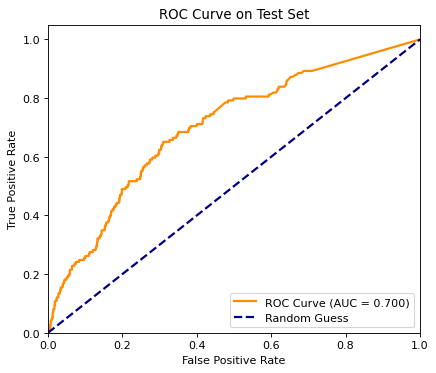

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# 获取预测的概率
y_prob_test = best_rf_final.predict_proba(X_test_final)[:, 1]

# 设置新阈值
threshold = 0.1
y_pred_new = (y_prob_test >= threshold).astype(int)

# 输出分类报告，包含精度、召回率、F1 分数等
print(classification_report(y_test, y_pred_new))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_new)
print("Confusion Matrix:")
print(cm)

# 从混淆矩阵中提取各个指标
TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if TP + FP != 0 else 0  # 防止除零错误
recall = TP / (TP + FN) if TP + FN != 0 else 0  # 防止除零错误
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# 计算 ROC 曲线和 AUC 值
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = roc_auc_score(y_test, y_prob_test)

# 绘制 ROC 曲线
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.show()

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb